# JAX-CFD demo

This initial demonstration shows how to use JAX-CFD to simulate decaying turbulence in 2D.

In [0]:
import jax
import jax.numpy as jnp
import jax_cfd.base as cfd
import numpy as np
import seaborn
import xarray

In [0]:
size = 256
density = 1.
viscosity = 1e-3
seed = 0
inner_steps = 25
outer_steps = 200

max_velocity = 2.0
cfl_safety_factor = 0.5

# Define the physical dimensions of the simulation.
grid = cfd.grids.Grid((size, size), domain=((0, 2 * jnp.pi), (0, 2 * jnp.pi)))

# Construct a random initial velocity. The `filtered_velocity_field` function
# ensures that the initial velocity is divergence free and it filters out
# high frequency fluctuations.
v0 = cfd.initial_conditions.filtered_velocity_field(
    jax.random.PRNGKey(seed), grid, max_velocity)

# Choose a time step.
dt = cfd.equations.stable_time_step(
    max_velocity, cfl_safety_factor, viscosity, grid)

# Define a step function and use it to compute a trajectory.
step_fn = cfd.funcutils.repeated(
    cfd.equations.semi_implicit_navier_stokes(
        density=density, viscosity=viscosity, dt=dt, grid=grid),
    steps=inner_steps)
rollout_fn = jax.jit(cfd.funcutils.trajectory(step_fn, outer_steps))
%time _, trajectory = jax.device_get(rollout_fn(v0))

CPU times: user 975 ms, sys: 54.9 ms, total: 1.03 s
Wall time: 838 ms


In [0]:
# JAX-CFD uses AlignedArray objects for input/output. These objects contain an
# "offset" that documents the location on the unit-cell that the fields
# correspond to.
with np.printoptions(edgeitems=1):
  print(trajectory)

(AlignedArray(data=array([[[-0.893504  , ..., -0.85155475],
        ...,
        [-0.90172863, ..., -0.8609534 ]],

       ...,

       [[-0.06770361, ..., -0.08866207],
        ...,
        [-0.0668979 , ..., -0.08822923]]], dtype=float32), offset=(1.0, 0.5)), AlignedArray(data=array([[[0.14294589, ..., 0.15117046],
        ...,
        [0.17220253, ..., 0.18040805]],

       ...,

       [[0.2864702 , ..., 0.28566447],
        ...,
        [0.274826  , ..., 0.2728846 ]]], dtype=float32), offset=(0.5, 1.0)))


In [0]:
# load into xarray for visualization and analysis
ds = xarray.Dataset(
    {
        'u': (('time', 'x', 'y'), trajectory[0].data),
        'v': (('time', 'x', 'y'), trajectory[1].data),
    },
    coords={
        'x': grid.axes()[0],
        'y': grid.axes()[1],
        'time': dt * inner_steps * np.arange(outer_steps)
    }
)

In [0]:
ds

<xarray.Dataset>
Dimensions:  (time: 200, x: 256, y: 256)
Coordinates:
  * x        (x) float32 0.012271847 0.03681554 ... 6.24637 6.2709136
  * y        (y) float32 0.012271847 0.03681554 ... 6.24637 6.2709136
  * time     (time) float64 0.0 0.1534 0.3068 0.4602 ... 30.07 30.22 30.37 30.53
Data variables:
    u        (time, x, y) float32 -0.893504 -0.9322965 ... -0.08822923
    v        (time, x, y) float32 0.14294589 0.13574128 ... 0.27160022 0.2728846

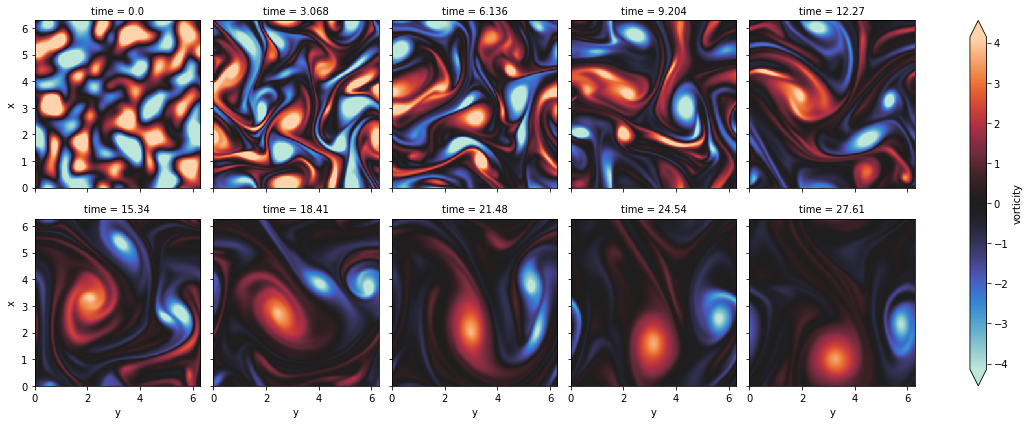

In [0]:
def vorticity(ds):
  return (ds.v.differentiate('x') - ds.u.differentiate('y')).rename('vorticity')

(ds.pipe(vorticity).thin(time=20)
 .plot.imshow(col='time', cmap=seaborn.cm.icefire, robust=True, col_wrap=5));